In [1]:
#General stuff
import time
import datetime
import glob
import re
import pandas as pd
from collections import Counter
import progressbar
import jellyfish
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import numpy as np
import statsmodels.formula.api as smf
from collections import Counter
from itertools import chain

## Pulling in all the files

In [2]:
df = pd.read_csv('data/df_final_harm.csv')

## I want to look for repetitions "sozialrechtliche Abteilungen"
And I'm working with the years, as the whole long string consisting of 15'000 verdicts is just too long. The Kernel dies regularly. Which really isn't much fun.

In [3]:
df_sozrecht = df[df['recht_harm'] == 'Sozialrecht']
sozrecht = df_sozrecht[df_sozrecht['Language'] == 'Fr']['Text-Nummer']

Splitting up the lists.

In [4]:
l = list(sozrecht)
n = 1000
txt_lsts = [l[i:i + n] for i in range(0, len(l), n)]

In [5]:
df_ = pd.DataFrame(columns=['index', 0])
bar = progressbar.ProgressBar()

for txt_lst, i in zip(txt_lsts, bar(range(len(txt_lsts)))):

    long_str = ''
    
    for txt in txt_lst:
    
        file = open('txt_files/' + txt, 'r')
        text = file.read()
        #Making sure the line breaks '/n', 'xa0' and double spaces are removed
        text = text.replace('\n', ' ').replace('\xa0', '').replace('  ', ' ')
        #Removing these automated notifications
        text = text.replace('Wichtiger Hinweis:Diese Website wird in älteren Versionen von Netscape ohne graphische Elemente dargestellt. Die Funktionalität der Website ist aber trotzdem gewährleistet. Wenn Sie diese Website regelmässig benutzen, empfehlen wir Ihnen, auf Ihrem Computer einen aktuellen Browser zu installieren.Zurück zur Einstiegsseite Drucken Grössere Schrift', '')
        text = text.replace('Vorwärts ähnliche Leitentscheide suchenähnliche Urteile ab 2000 suchen Drucken nach oben', '')
        text = text.replace('Bundesgericht Tribunal fédéral Tribunale federale Tribunal federal', '')
        text = text.replace('Navigation Neue Suche Zurück zum Suchresultat Rang: Zurück 180', '')
        text = text.replace('Navigation Neue Suche Zurück zum Suchresultat Rang:1 ähnliche Leitentscheide suchenähnliche Urteile ab 2000 suchen Drucken nach oben', '')
    
        long_str = long_str + text
        
    df_new = pd.DataFrame(pd.Series( long_str[ix:ix+500] for ix in list(range(len(long_str))) ).value_counts()).reset_index()
    df_new = df_new[df_new[0]> 1]
    
    frames = [df_, df_new]
    df_ = pd.concat(frames)
    

 83% (5 of 6) |#######################     | Elapsed Time: 0:03:54 ETA: 0:00:46

# Saving off the result
Later, I can just jump to this step, I don't need to repeat the steps above

In [6]:
df_.to_csv('500Characters.csv')

In [7]:
df_ = pd.read_csv('500Characters.csv')

In [8]:
del df_['Unnamed: 0']

In [9]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 932147 entries, 0 to 932146
Data columns (total 2 columns):
index    932147 non-null object
0        932147 non-null float64
dtypes: float64(1), object(1)
memory usage: 14.2+ MB


In [10]:
df_.columns = [['String', 'Count']]

# Deleting Duplicates

In [11]:
df_ = df_.drop_duplicates(subset='String', keep='first')

In [12]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800788 entries, 0 to 932146
Data columns (total 2 columns):
String    800788 non-null object
Count     800788 non-null float64
dtypes: float64(1), object(1)
memory usage: 18.3+ MB


In [13]:
df = df_[df_['Count'] >= 10]

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23273 entries, 0 to 692419
Data columns (total 2 columns):
String    23273 non-null object
Count     23273 non-null float64
dtypes: float64(1), object(1)
memory usage: 545.5+ KB


# Matching similar Strings
Using Jellyfish and remodelling the original df, using it to create a new list of string. Because these ones are the ones I don't need to consider anymore.

In [15]:
df_new = pd.DataFrame(columns=['String', 'Count', 'Jaro'])

for count in range(1000):
    
    print(count)
    string_list = list(df['String'])
    value_list = []
    bar = progressbar.ProgressBar()

    for elem, i in zip(string_list, bar(range(len(string_list)))):
    
        value = jellyfish.jaro_distance(string_list[0], elem)
        value_list.append(value)
    
    df['Jaro'] = value_list
    df_unique = df[df['Jaro'] >= .825].head(1)

    frames = [df_new, df_unique]
    df_new = pd.concat(frames)

    df = df[df['Jaro'] <= .825]
    del df['Jaro']

  1% (295 of 23273) |                     | Elapsed Time: 0:00:00 ETA:  0:00:00

0


 97% (22684 of 23273) |################### | Elapsed Time: 0:00:03 ETA: 0:00:00/Users/barneyjs/.virtualenvs/master/lib/python3.5/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
  5% (1161 of 22921) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:03

1


  5% (1156 of 22821) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:03

2


  5% (1147 of 22648) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:03

3


  5% (1140 of 22503) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:03

4


  5% (1125 of 22214) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:03

5


  5% (1124 of 22190) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

6


  5% (1120 of 22103) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:03

7


  5% (1113 of 21971) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

8


  5% (1105 of 21817) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

9


  5% (1102 of 21745) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

10


  5% (1090 of 21524) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

11


  5% (1084 of 21407) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

12


  5% (1084 of 21390) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

13


  5% (1072 of 21172) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

14


  5% (1069 of 21105) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

15


  5% (1062 of 20964) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

16


  5% (1061 of 20941) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

17


  5% (1060 of 20932) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

18


  5% (1060 of 20927) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

19


  5% (1059 of 20912) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

20


  5% (1059 of 20905) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

21


  5% (1056 of 20841) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

22


  5% (1054 of 20814) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

23


  5% (1054 of 20806) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

24


  5% (1053 of 20788) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

25


  5% (1049 of 20717) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

26


  5% (1046 of 20641) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

27


  5% (1043 of 20583) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

28


  5% (1039 of 20514) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

29


  5% (1037 of 20467) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

30


  5% (1034 of 20418) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

31


  5% (1033 of 20390) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

32


  5% (1030 of 20341) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

33


  5% (1030 of 20331) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

34


  5% (1029 of 20317) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

35


  5% (1027 of 20279) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

36


  5% (1022 of 20165) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

37


  5% (1018 of 20103) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

38


  5% (1017 of 20081) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

39


  5% (1016 of 20049) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

40


  5% (1012 of 19977) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:03

41


  5% (1012 of 19968) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:03

42


  5% (1011 of 19949) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

43


  5% (1010 of 19932) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

44


  5% (1007 of 19888) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

45


  5% (1006 of 19866) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:03

46


  5% (1002 of 19787) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:03

47


  5% (998 of 19699) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:03

48


  5% (995 of 19641) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

49


  5% (991 of 19556) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

50


  5% (989 of 19521) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

51


  5% (987 of 19486) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

52


  5% (985 of 19449) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

53


  5% (985 of 19439) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

54


  5% (982 of 19390) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

55


  5% (981 of 19359) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:03

56


  5% (981 of 19358) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

57


  5% (980 of 19340) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

58


  5% (976 of 19267) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

59


  5% (973 of 19211) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:03

60


  5% (970 of 19147) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

61


  5% (968 of 19104) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

62


  5% (964 of 19028) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

63


  5% (961 of 18962) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

64


  5% (958 of 18905) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

65


  5% (957 of 18885) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

66


  5% (954 of 18832) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

67


  5% (953 of 18805) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

68


  5% (952 of 18795) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

69


  5% (952 of 18785) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

70


  5% (952 of 18784) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

71


  5% (950 of 18752) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

72


  5% (950 of 18751) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

73


  5% (942 of 18595) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

74


  5% (938 of 18510) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

75


  5% (935 of 18453) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

76


  5% (932 of 18394) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

77


  5% (929 of 18329) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

78


  7% (1388 of 18273) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

79


  5% (921 of 18184) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

80


  5% (919 of 18147) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

81


  5% (917 of 18094) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:03

82


  5% (916 of 18089) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

83


  5% (916 of 18081) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

84


  5% (910 of 17972) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

85


  5% (908 of 17927) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

86


  5% (906 of 17887) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

87


  5% (903 of 17824) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:03

88


  5% (902 of 17802) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

89


  5% (898 of 17735) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

90


  5% (898 of 17724) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

91


  5% (898 of 17716) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

92


  5% (896 of 17691) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

93


  5% (896 of 17687) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:03

94


  5% (895 of 17663) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

95


  5% (892 of 17609) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

96


  5% (892 of 17605) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

97


  5% (887 of 17500) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

98


  7% (1327 of 17464) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

99


  6% (1102 of 17407) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

100


  5% (879 of 17358) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

101


  5% (877 of 17317) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

102


  5% (875 of 17279) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

103


  7% (1313 of 17275) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

104


  5% (873 of 17237) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

105


  5% (872 of 17220) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

106


  7% (1303 of 17153) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

107


  5% (869 of 17147) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

108


  5% (868 of 17135) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

109


  5% (867 of 17114) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

110


  7% (1300 of 17108) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

111


  7% (1300 of 17106) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

112


  2% (433 of 17093) |                      | Elapsed Time: 0:00:00 ETA: 0:00:04

113


  7% (1297 of 17071) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

114


  7% (1297 of 17070) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

115


  7% (1292 of 17008) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

116


  7% (1288 of 16953) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

117


  7% (1285 of 16914) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

118


  5% (855 of 16885) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

119


  7% (1280 of 16851) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

120


  7% (1275 of 16775) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

121


  7% (1274 of 16767) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

122


  7% (1273 of 16759) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

123


  7% (1273 of 16756) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

124


  5% (846 of 16693) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

125


  7% (1262 of 16615) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

126


  7% (1258 of 16553) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

127


  7% (1255 of 16522) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

128


  7% (1254 of 16509) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

129


  7% (1251 of 16468) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

130


  7% (1251 of 16464) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

131


  7% (1251 of 16463) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

132


  7% (1250 of 16457) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

133


  7% (1250 of 16452) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

134


  7% (1246 of 16401) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

135


  7% (1244 of 16368) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

136


  7% (1240 of 16315) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

137


  7% (1234 of 16241) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

138


  7% (1232 of 16218) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

139


  7% (1230 of 16195) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

140


  7% (1230 of 16194) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

141


  7% (1228 of 16163) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

142


  7% (1228 of 16157) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

143


  7% (1223 of 16098) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

144


  7% (1223 of 16091) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

145


  7% (1221 of 16067) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

146


  7% (1221 of 16065) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

147


  7% (1221 of 16064) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

148


  7% (1217 of 16021) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

149


  7% (1212 of 15956) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

150


  7% (1205 of 15864) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

151


  7% (1198 of 15762) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

152


  7% (1196 of 15735) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

153


  7% (1193 of 15704) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

154


  7% (1191 of 15678) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

155


  7% (1190 of 15660) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

156


  7% (1190 of 15658) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

157


  7% (1187 of 15624) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

158


  7% (1185 of 15591) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

159


  7% (1185 of 15590) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

160


  7% (1184 of 15589) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

161


  7% (1184 of 15588) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

162


  7% (1180 of 15530) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

163


  7% (1174 of 15454) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

164


  7% (1170 of 15397) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

165


  7% (1166 of 15343) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

166


  7% (1163 of 15305) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

167


  5% (772 of 15231) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

168


  7% (1156 of 15210) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

169


  5% (766 of 15128) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

170


  5% (763 of 15063) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:03

171


  7% (1141 of 15015) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

172


  7% (1136 of 14954) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

173


  5% (755 of 14907) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

174


  7% (1132 of 14892) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

175


  7% (1127 of 14835) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

176


  5% (749 of 14783) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

177


  7% (1120 of 14742) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

178


  7% (1119 of 14723) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

179


  7% (1118 of 14710) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

180


  5% (745 of 14708) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

181


  5% (745 of 14707) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

182


  5% (745 of 14706) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

183


  7% (1117 of 14703) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

184


  7% (1116 of 14691) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

185


  8% (1299 of 14657) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

186


  7% (1107 of 14568) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

187


  7% (1106 of 14554) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

188


  5% (737 of 14551) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

189


  7% (1104 of 14527) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

190


  7% (1097 of 14441) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

191


  7% (1092 of 14365) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

192


  7% (1085 of 14279) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

193


  7% (1081 of 14226) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

194


  5% (720 of 14217) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

195


  7% (1080 of 14216) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

196


  5% (715 of 14117) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

197


  7% (1071 of 14100) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

198


  7% (1065 of 14017) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

199


  8% (1237 of 13960) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

200


  7% (1055 of 13878) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

201


  7% (1048 of 13789) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

202


  8% (1220 of 13759) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

203


  8% (1214 of 13691) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

204


  5% (693 of 13674) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

205


  7% (1036 of 13628) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

206


  7% (1032 of 13586) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

207


 10% (1372 of 13540) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

208


  7% (1025 of 13484) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

209


 10% (1363 of 13450) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

210


  8% (1190 of 13429) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

211


  8% (1190 of 13427) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

212


  7% (1020 of 13418) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

213


  7% (1019 of 13412) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

214


  7% (1019 of 13408) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

215


 10% (1358 of 13406) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

216


  7% (1019 of 13405) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

217


  7% (1018 of 13400) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

218


  7% (1018 of 13399) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

219


 10% (1345 of 13280) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

220


  8% (1172 of 13225) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

221


  7% (1001 of 13175) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

222


  8% (1164 of 13135) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

223


  7% (988 of 13007) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

224


  8% (1147 of 12940) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

225


  7% (977 of 12859) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

226


  8% (1136 of 12812) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

227


  7% (971 of 12784) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

228


  6% (809 of 12768) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

229


  3% (484 of 12740) |                      | Elapsed Time: 0:00:00 ETA: 0:00:03

230


  7% (966 of 12717) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

231


  7% (964 of 12680) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

232


  8% (1121 of 12649) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

233


  5% (641 of 12643) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

234


  8% (1120 of 12640) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

235


  7% (960 of 12639) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

236


  7% (953 of 12545) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

237


  7% (950 of 12502) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

238


  7% (948 of 12475) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

239


  7% (948 of 12471) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

240


  7% (946 of 12448) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

241


  8% (1103 of 12441) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

242


  8% (1098 of 12389) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

243


  6% (781 of 12327) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:03

244


  8% (1086 of 12253) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

245


  7% (931 of 12247) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

246


  7% (930 of 12242) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

247


  8% (1085 of 12239) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

248


  5% (619 of 12209) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

249


  7% (925 of 12171) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

250


  8% (1079 of 12169) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

251


  7% (924 of 12166) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

252


  3% (455 of 12123) |                      | Elapsed Time: 0:00:00 ETA: 0:00:04

253


  7% (917 of 12065) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

254


  7% (916 of 12058) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

255


  5% (611 of 12057) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

256


  7% (916 of 12056) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

257


  7% (916 of 12050) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

258


  7% (915 of 12037) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

259


  7% (912 of 11998) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

260


  7% (906 of 11922) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

261


 10% (1204 of 11881) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

262


  7% (901 of 11857) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

263


  7% (899 of 11834) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

264


  7% (895 of 11776) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

265


  7% (892 of 11734) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

266


  8% (1034 of 11668) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

267


  7% (882 of 11613) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

268


 11% (1317 of 11552) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

269


 11% (1314 of 11533) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

270


  7% (876 of 11526) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

271


 11% (1311 of 11500) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

272


 11% (1305 of 11454) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

273


 11% (1300 of 11409) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

274


  7% (866 of 11395) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

275


 11% (1299 of 11394) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

276


 11% (1296 of 11369) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

277


  7% (863 of 11361) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

278


 11% (1280 of 11233) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

279


 11% (1264 of 11090) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

280


 11% (1259 of 11043) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

281


  8% (979 of 11039) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

282


  7% (837 of 11018) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

283


  7% (834 of 10979) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

284


  7% (833 of 10965) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

285


  7% (828 of 10895) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

286


  7% (822 of 10812) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

287


  7% (819 of 10772) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

288


  7% (812 of 10687) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

289


  5% (539 of 10629) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

290


  7% (804 of 10578) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

291


  7% (798 of 10495) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

292


 11% (1189 of 10430) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

293


  7% (784 of 10321) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

294


  8% (906 of 10217) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

295


  7% (769 of 10123) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

296


  8% (891 of 10052) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

297


 11% (1137 of 9976) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

298


 11% (1129 of 9907) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

299


 11% (1123 of 9851) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

300


 11% (1107 of 9713) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

301


 11% (1103 of 9677) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

302


 11% (1095 of 9603) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

303


 11% (1087 of 9533) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

304


 11% (1074 of 9421) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

305


 11% (1069 of 9378) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

306


 11% (1063 of 9326) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

307


 11% (1057 of 9270) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

308


 11% (1047 of 9189) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

309


 11% (1039 of 9115) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

310


 11% (1030 of 9034) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

311


 11% (1026 of 8998) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

312


 11% (1016 of 8917) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

313


 11% (1011 of 8871) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

314


 15% (1331 of 8759) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

315


 12% (1103 of 8710) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

316


 15% (1314 of 8650) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

317


 15% (1307 of 8599) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

318


 12% (1080 of 8531) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

319


 11% (962 of 8441) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

320


 15% (1273 of 8378) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

321


 15% (1265 of 8325) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

322


 15% (1260 of 8290) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

323


 15% (1251 of 8230) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

324


 15% (1239 of 8154) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

325


 15% (1223 of 8046) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

326


 15% (1216 of 8003) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

327


 15% (1211 of 7971) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

328


 15% (1207 of 7943) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

329


 15% (1199 of 7889) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

330


 13% (1089 of 7819) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

331


 15% (1183 of 7783) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

332


 15% (1176 of 7737) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

333


 15% (1172 of 7710) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

334


 15% (1158 of 7617) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

335


 15% (1152 of 7579) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

336


 15% (1142 of 7517) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

337


 15% (1138 of 7490) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

338


 11% (851 of 7465) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

339


 12% (940 of 7419) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

340


 11% (835 of 7327) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

341


 13% (1018 of 7309) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

342


 12% (922 of 7276) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

343


 15% (1095 of 7204) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

344


 12% (910 of 7186) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

345


 13% (999 of 7169) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:01

346


 12% (906 of 7155) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

347


 13% (991 of 7116) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:01

348


 12% (899 of 7095) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

349


 15% (1065 of 7006) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

350


 12% (887 of 7001) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

351


 13% (973 of 6985) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:01

352


 15% (1060 of 6975) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

353


 12% (877 of 6927) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

354


 15% (1045 of 6875) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

355


 15% (1041 of 6848) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

356


 13% (949 of 6814) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:01

357


 15% (1026 of 6752) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

358


 15% (1019 of 6705) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

359


 13% (928 of 6662) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:00

360


 13% (924 of 6629) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:00

361


 13% (921 of 6612) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:01

362


 16% (1077 of 6544) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

363


 15% (990 of 6513) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:00

364


 15% (985 of 6483) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:01

365


 16% (1060 of 6441) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

366


 15% (979 of 6439) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:00

367


 15% (978 of 6435) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:01

368


 15% (972 of 6397) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:01

369


 15% (970 of 6381) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:00

370


 13% (886 of 6363) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:01

371


 16% (1045 of 6346) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

372


 18% (1199 of 6312) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

373


 16% (1039 of 6308) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

374


 15% (957 of 6294) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:01

375


 13% (875 of 6280) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:01

376


 12% (794 of 6271) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

377


 11% (713 of 6258) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

378


 15% (950 of 6251) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:00

379


  8% (554 of 6249) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

380


 15% (948 of 6235) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:00

381


 17% (1103 of 6219) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

382


 13% (864 of 6198) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:01

383


 12% (785 of 6196) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

384


 15% (938 of 6175) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:01

385


 15% (938 of 6173) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:00

386


 18% (1172 of 6172) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

387


 15% (938 of 6171) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:00

388


 19% (1172 of 6168) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

389


 18% (1167 of 6145) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

390


 18% (1163 of 6122) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

391


 18% (1159 of 6103) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

392


 16% (993 of 6031) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:00

393


 15% (906 of 5964) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:00

394


 18% (1118 of 5888) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

395


  8% (511 of 5760) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:02

396


 18% (1079 of 5679) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

397


 12% (709 of 5598) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

398


 13% (771 of 5535) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:01

399


 13% (760 of 5455) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:01

400


 18% (1016 of 5350) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

401


 20% (1071 of 5287) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

402


 18% (988 of 5202) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

403


 16% (845 of 5133) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:00

404


 21% (1080 of 5015) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

405


 22% (1122 of 4922) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

406


 22% (1097 of 4811) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

407


 21% (1020 of 4738) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

408


 16% (767 of 4659) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:00

409


 22% (1042 of 4571) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

410


 21% (977 of 4540) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

411


 18% (852 of 4485) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

412


 18% (846 of 4454) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

413


 21% (944 of 4384) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

414


 17% (769 of 4337) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

415


 21% (918 of 4262) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

416


 22% (947 of 4155) |#####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

417


 15% (623 of 4097) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:00

418


 17% (712 of 4017) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

419


 17% (707 of 3987) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

420


 20% (796 of 3929) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

421


 15% (587 of 3864) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:00

422


 18% (722 of 3801) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

423


 12% (472 of 3727) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

424


  3% (139 of 3651) |                      | Elapsed Time: 0:00:00 ETA:  0:00:00

425


 16% (586 of 3560) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:00

426


 19% (669 of 3521) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

427


 24% (837 of 3479) |#####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

428


 24% (829 of 3445) |#####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

429


 29% (976 of 3349) |######                 | Elapsed Time: 0:00:00 ETA: 0:00:00

430


 30% (998 of 3283) |######                 | Elapsed Time: 0:00:00 ETA: 0:00:00

431


 32% (1069 of 3246) |#######               | Elapsed Time: 0:00:00 ETA: 0:00:00

432


 32% (1040 of 3158) |#######               | Elapsed Time: 0:00:00 ETA: 0:00:00

433


 34% (1061 of 3102) |#######               | Elapsed Time: 0:00:00 ETA: 0:00:00

434


 31% (957 of 3022) |#######                | Elapsed Time: 0:00:00 ETA: 0:00:00

435


 34% (1012 of 2960) |#######               | Elapsed Time: 0:00:00 ETA: 0:00:00

436


 36% (1050 of 2860) |########              | Elapsed Time: 0:00:00 ETA: 0:00:00

437


 38% (1068 of 2810) |########              | Elapsed Time: 0:00:00 ETA: 0:00:00

438


 24% (660 of 2743) |#####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

439


 37% (1038 of 2733) |########              | Elapsed Time: 0:00:00 ETA: 0:00:00

440


 40% (1080 of 2666) |########              | Elapsed Time: 0:00:00 ETA: 0:00:00

441


 41% (1102 of 2638) |#########             | Elapsed Time: 0:00:00 ETA: 0:00:00

442


 41% (1074 of 2571) |#########             | Elapsed Time: 0:00:00 ETA: 0:00:00

443


 41% (1068 of 2556) |#########             | Elapsed Time: 0:00:00 ETA: 0:00:00

444


 41% (1052 of 2518) |#########             | Elapsed Time: 0:00:00 ETA: 0:00:00

445


 41% (1030 of 2465) |#########             | Elapsed Time: 0:00:00 ETA: 0:00:00

446


 41% (1020 of 2440) |#########             | Elapsed Time: 0:00:00 ETA: 0:00:00

447


 38% (908 of 2389) |########               | Elapsed Time: 0:00:00 ETA: 0:00:00

448


 34% (814 of 2380) |#######                | Elapsed Time: 0:00:00 ETA: 0:00:00

449


 32% (761 of 2310) |#######                | Elapsed Time: 0:00:00 ETA: 0:00:00

450


 31% (713 of 2251) |#######                | Elapsed Time: 0:00:00 ETA: 0:00:00

451


 34% (759 of 2220) |#######                | Elapsed Time: 0:00:00 ETA: 0:00:00

452


 46% (1019 of 2175) |##########            | Elapsed Time: 0:00:00 ETA: 0:00:00

453


 34% (725 of 2119) |#######                | Elapsed Time: 0:00:00 ETA: 0:00:00

454


 49% (1043 of 2111) |##########            | Elapsed Time: 0:00:00 ETA: 0:00:00

455


 35% (746 of 2103) |########               | Elapsed Time: 0:00:00 ETA: 0:00:00

456


 50% (1057 of 2086) |###########           | Elapsed Time: 0:00:00 ETA: 0:00:00

457


 41% (861 of 2059) |#########              | Elapsed Time: 0:00:00 ETA: 0:00:00

458


 45% (931 of 2041) |##########             | Elapsed Time: 0:00:00 ETA: 0:00:00

459


 43% (878 of 2039) |#########              | Elapsed Time: 0:00:00 ETA: 0:00:00

460


 49% (982 of 1988) |###########            | Elapsed Time: 0:00:00 ETA: 0:00:00

461


 44% (870 of 1962) |##########             | Elapsed Time: 0:00:00 ETA: 0:00:00

462


 50% (989 of 1953) |###########            | Elapsed Time: 0:00:00 ETA: 0:00:00

463


 54% (1053 of 1933) |###########           | Elapsed Time: 0:00:00 ETA: 0:00:00

464


 48% (912 of 1895) |###########            | Elapsed Time: 0:00:00 ETA: 0:00:00

465


 53% (1002 of 1884) |###########           | Elapsed Time: 0:00:00 ETA: 0:00:00

466


 55% (1044 of 1873) |############          | Elapsed Time: 0:00:00 ETA: 0:00:00

467


 57% (1061 of 1861) |############          | Elapsed Time: 0:00:00 ETA: 0:00:00

468


 55% (1035 of 1858) |############          | Elapsed Time: 0:00:00 ETA: 0:00:00

469


 55% (1034 of 1855) |############          | Elapsed Time: 0:00:00 ETA: 0:00:00

470


 54% (1010 of 1854) |###########           | Elapsed Time: 0:00:00 ETA: 0:00:00

471


 49% (913 of 1849) |###########            | Elapsed Time: 0:00:00 ETA: 0:00:00

472


 55% (1029 of 1847) |############          | Elapsed Time: 0:00:00 ETA: 0:00:00

473


 54% (984 of 1806) |############           | Elapsed Time: 0:00:00 ETA: 0:00:00

474


 54% (981 of 1801) |############           | Elapsed Time: 0:00:00 ETA: 0:00:00

475


 54% (978 of 1795) |############           | Elapsed Time: 0:00:00 ETA: 0:00:00

476


 57% (1021 of 1791) |############          | Elapsed Time: 0:00:00 ETA: 0:00:00

477


 53% (951 of 1787) |############           | Elapsed Time: 0:00:00 ETA: 0:00:00

478


 40% (717 of 1768) |#########              | Elapsed Time: 0:00:00 ETA: 0:00:00

479


 56% (1004 of 1762) |############          | Elapsed Time: 0:00:00 ETA: 0:00:00

480


 51% (913 of 1759) |###########            | Elapsed Time: 0:00:00 ETA: 0:00:00

481


 56% (1002 of 1758) |############          | Elapsed Time: 0:00:00 ETA: 0:00:00

482


 54% (956 of 1755) |############           | Elapsed Time: 0:00:00 ETA: 0:00:00

483


 60% (1063 of 1748) |#############         | Elapsed Time: 0:00:00 ETA: 0:00:00

484


 56% (990 of 1738) |#############          | Elapsed Time: 0:00:00 ETA: 0:00:00

485


 59% (1034 of 1737) |#############         | Elapsed Time: 0:00:00 ETA: 0:00:00

486


 59% (1033 of 1735) |#############         | Elapsed Time: 0:00:00 ETA: 0:00:00

487


 58% (1008 of 1731) |############          | Elapsed Time: 0:00:00 ETA: 0:00:00

488


 59% (1017 of 1708) |#############         | Elapsed Time: 0:00:00 ETA: 0:00:00

489


 60% (1036 of 1704) |#############         | Elapsed Time: 0:00:00 ETA: 0:00:00

490


 64% (1100 of 1703) |##############        | Elapsed Time: 0:00:00 ETA: 0:00:00

491


 59% (1013 of 1702) |#############         | Elapsed Time: 0:00:00 ETA: 0:00:00

492


 60% (1033 of 1700) |#############         | Elapsed Time: 0:00:00 ETA: 0:00:00

493


 58% (990 of 1699) |#############          | Elapsed Time: 0:00:00 ETA: 0:00:00

494


 59% (1004 of 1686) |#############         | Elapsed Time: 0:00:00 ETA: 0:00:00

495


 64% (1032 of 1598) |##############        | Elapsed Time: 0:00:00 ETA: 0:00:00

496


 54% (830 of 1524) |############           | Elapsed Time: 0:00:00 ETA: 0:00:00

497


 62% (876 of 1411) |##############         | Elapsed Time: 0:00:00 ETA: 0:00:00

498


 59% (806 of 1354) |#############          | Elapsed Time: 0:00:00 ETA: 0:00:00

499


 60% (790 of 1299) |#############          | Elapsed Time: 0:00:00 ETA: 0:00:00

500


 78% (984 of 1253) |##################     | Elapsed Time: 0:00:00 ETA: 0:00:00

501


 88% (1067 of 1204) |###################   | Elapsed Time: 0:00:00 ETA: 0:00:00

502


 88% (1020 of 1151) |###################   | Elapsed Time: 0:00:00 ETA: 0:00:00

503


 88% (949 of 1071) |####################   | Elapsed Time: 0:00:00 ETA: 0:00:00

504


N/A% (0 of 896) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

505
506


N/A% (0 of 723) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

507
508


N/A% (0 of 647) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

509
510


N/A% (0 of 557) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

511
512


N/A% (0 of 471) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

513
514


N/A% (0 of 429) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

515
516


 88% (357 of 402) |####################   | Elapsed Time: 0:00:00 ETA:  0:00:00

517
518


N/A% (0 of 346) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

519
520
521

N/A% (0 of 250) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


522
523
524


N/A% (0 of 79) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

525
526
527
528


N/A% (0 of 33) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

529
530
531
532
533


N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

534
535
536
537
538


N/A% (0 of 1) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788


# Cleaning the New DF and Creating a String

In [16]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541 entries, 0 to 692036
Data columns (total 3 columns):
String    541 non-null object
Count     541 non-null float64
Jaro      541 non-null float64
dtypes: float64(2), object(1)
memory usage: 16.9+ KB


In [17]:
del df_new['Count']

In [18]:
del df_new['Jaro']

In [19]:
len(list(df_new['String']))

541

In [20]:
string_list = list(df_new['String'])

# Iterating through all the files

Functions to pull out relevant information

In [21]:
REGEXES_SCHREIBER = [
    r'[gG]reffier\s*:*\s*\w*\.*\s*\w*',
    r'[Gg]reffière\s*:*\s*\w*\.*\s*\w*',
    r'[gG]erichtsschr eiberi*n*\s*:* \w*\.*\s*\w*',
    r'[Cc]ancelliere*n*\s*:* \w*\.*\s*\w*']

In [22]:
def gerichtsschreiber(doc):
    try:
        text = next(chain.from_iterable(re.finditer(r, doc) for r in REGEXES_SCHREIBER), None)
        return text.group()
    except:
        None

In [23]:
def extracting_date(doc):
    Datum = re.findall(r"[0-9]+\.[0-9]+\.20[0-9]+", doc)
    try:
        return Datum[0]
    except:
        pass

In [24]:
def extracting_akten_nummer(doc):
    an = re.findall(r"[0-9]*[A-Z][.]*[_]*[ ]*[0-9]+/[0-9]+", doc)
    try:
        an = an[0]
        an = an.replace('_', ' ')
        return an
    except:
        pass

In [25]:
l = list(sozrecht)

In [26]:
txt_elems = []
bar = progressbar.ProgressBar()

for text_file, i in zip(l, bar((range(len(l))))):
    
    file = open('txt_files/' + text_file, 'r')
    text = file.read()
    file.close()
    
    #Special formatting
    text = text.replace('\n', ' ').replace('\xa0', '').replace('  ', '')
    text = text.replace('  ', ' ')
    
    Datum = extracting_date(text)
    Aktennummer = extracting_akten_nummer(text)
    Gerichtsschreiber = gerichtsschreiber(text)
    
    
    if string_list[0] in text:
        boolean = 1
    else:
        boolean = 0
    
    mini_dict = {'Text Nummer': text_file,
                 'Datum': Datum,
                 string_list[0][:20]: boolean,
                 'Aktennummer': Aktennummer,
                 'Gerichtsschreiber': Gerichtsschreiber}
    
    txt_elems.append(mini_dict)

 98% (5239 of 5306) |##################### | Elapsed Time: 0:00:07 ETA: 0:00:00

In [27]:
df_bools = pd.DataFrame(txt_elems)

# Repeat what I did above, now attaching the lists to df_bools

In [28]:
bar = progressbar.ProgressBar()

for string, i in zip(string_list, bar(range(len(string_list)))):
    
    bool_list = []
    
    for text_file in l:
    
        file = open('txt_files/' + text_file, 'r')
        text = file.read()
        file.close()
    
        #Special formatting
        text = text.replace('\n', ' ').replace('\xa0', '').replace('  ', '')
        text = text.replace('  ', ' ')
    
        if string in text:
            boolean = 1
        else:
            boolean = 0
        
        bool_list.append(boolean)
    
    df_bools[string[:20]] = bool_list

 99% (540 of 541) |####################### | Elapsed Time: 0:08:12 ETA: 0:00:00

In [29]:
df_bools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5306 entries, 0 to 5305
Columns: 537 entries, Aktennummer to 5 1205, 1242) de la 
dtypes: int64(533), object(4)
memory usage: 21.7+ MB


In [30]:
df_bools.to_csv('bools900text_snippets_fr_soz.csv')

In [31]:
df_bools = pd.read_csv('bools900text_snippets_fr_soz.csv')

In [32]:
del df_bools['Unnamed: 0']

In [33]:
df_bools['Gerichtsschreiber'].value_counts()

Greffier: M. Piguet              491
Greffière: Mme Moser             483
Greffier: M. Cretton             440
Greffier: M. Beauverd            379
Greffière: Mme Fretz             340
Greffier: M. Berthoud            328
Greffier: M. Wagner              319
Greffière: Mme von               296
Greffière: Mme Berset            296
Greffier: M. Métral              215
Greffier: M. Bouverat            165
Greffier : M. Cretton            146
Greffière : Mme Castella         143
Greffier : M. Berthoud           135
Greffier : M. Beauverd           129
Greffière : Mme von              121
Greffier : M. Piguet             118
Greffière: Mme Reichen           117
Greffière : Mme Fretz            116
Greffière : Mme Flury            110
Greffier : M. Bleicker            90
Greffier: M. Scartazzini          85
Greffière: Mme Gehring            78
Greffière : Mme Moser             41
Greffier : M. Wagner              27
Greffière : Mme Indermühle        24
Greffier: M. Hichri               20
G

# Making Total Column

In [34]:
df_bools['TOTAL'] = df_bools.sum(axis=1, numeric_only=True)

In [35]:
df_bools['TOTAL'].describe()

count    5306.000000
mean        2.329250
std         5.277195
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        63.000000
Name: TOTAL, dtype: float64

# Dates

In [36]:
df_bools['Datetime'] = pd.to_datetime(df_bools['Datum'], format="%d.%m.%Y")
df_bools.index = df_bools['Datetime']

# Plotting and Linear Regression

In [37]:
df_counts_pyear = pd.DataFrame(df_bools.resample('A')['TOTAL'].sum()).reset_index()

In [38]:
def change(elem):
    elem = str(elem)
    elem = int(elem.replace('-12-31 00:00:00', ''))
    return elem

In [39]:
df_counts_pyear

,Datetime,TOTAL
0,2007-12-31,696
1,2008-12-31,1446
2,2009-12-31,623
3,2010-12-31,1391
4,2011-12-31,1744
5,2012-12-31,1287
6,2013-12-31,1292
7,2014-12-31,1185
8,2015-12-31,1116
9,2016-12-31,1092


In [40]:
df_counts_pyear['Years'] = df_counts_pyear['Datetime'].apply(change)

In [41]:
lm = smf.ols(formula="TOTAL~Years",data=df_counts_pyear).fit()

In [42]:
lm.params

Intercept    34888.563636
Years          -16.781818
dtype: float64

In [43]:
intercept, slope = lm.params

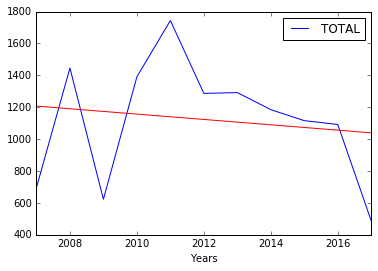

In [44]:
df_counts_pyear.plot(x="Years",y="TOTAL")
plt.plot(df_counts_pyear["Years"],slope*df_counts_pyear["Years"]+intercept,"-",color="red") 

# Without 2017

In [63]:
df_2007_2016 = df_counts_pyear[df_counts_pyear['Years'] != 2017]

In [64]:
lm = smf.ols(formula="TOTAL~Years",data=df_2007_2016).fit()

In [65]:
lm.params

Intercept   -39164.709091
Years           20.060606
dtype: float64

In [66]:
intercept, slope = lm.params

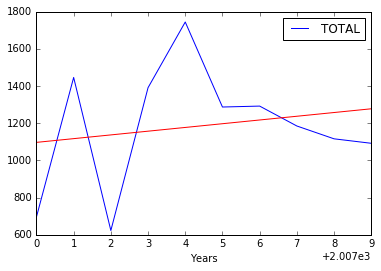

In [67]:
df_2007_2016.plot(x="Years",y="TOTAL")
plt.plot(df_2007_2016["Years"],slope*df_2007_2016["Years"]+intercept,"-",color="red")

In [144]:
df_2007_2016.to_csv('2007_2016_soz_fr.csv')

# Harmonising the Gerichtsschreiber

In [110]:
def harm(elem):
    try:
        elem = elem.replace('Greffier: ', '').replace('Greffière: ', '')
        elem = elem.replace('Greffier : ', '').replace('Greffière : ', '')
        elem = elem.replace('M. ', '').replace('Mme ', '')
        elem = elem.replace('M ', '').replace('Mme ', '')
        return elem
    except:
        None

In [111]:
df_bools['Schreiber harm'] = df_bools['Gerichtsschreiber'].apply(harm)

In [112]:
df_bools.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5306 entries, 2015-09-04 to 2007-04-02
Columns: 540 entries, Aktennummer to Schreiber harm
dtypes: datetime64[ns](1), int64(534), object(5)
memory usage: 21.9+ MB


In [113]:
df_bools['Schreiber harm'].value_counts().head()

Piguet      609
Cretton     586
Moser       524
Beauverd    508
Berthoud    463
Name: Schreiber harm, dtype: int64

# Merging with large file to sort out Abgeschrieben/Nichteingetreten

In [114]:
df = pd.read_csv('data/df_final_harm.csv')
df = df[['Aktennummer', 'Entscheid_harm']].copy()
df_ = df_bools.merge(df, left_on='Aktennummer', right_on='Aktennummer')
df_ = df_[df_['Entscheid_harm'] != 'Nicht eingetreten']

In [115]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3781 entries, 0 to 5309
Columns: 541 entries, Aktennummer to Entscheid_harm
dtypes: datetime64[ns](1), int64(534), object(6)
memory usage: 15.6+ MB


# Working out, total by Clerk

In [116]:
df_totalelems = pd.DataFrame(df_.groupby('Schreiber harm')['TOTAL'].sum().sort_values(ascending=False))

# Working out number of appeals, we counted their involvement in

In [117]:
df = pd.read_csv('data/df_final_harm.csv')
df = df[df['Entscheid_harm'] != 'Nicht eingetreten']

In [118]:
df_sozrecht = df[df['recht_harm'] == 'Sozialrecht']

In [119]:
df_sozrecht['Schreiber_harm'] = df_sozrecht['Schreiber_harm'].apply(harm)

/Users/barneyjs/.virtualenvs/master/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [134]:
df_totalappeals = pd.DataFrame(df_sozrecht['Schreiber_harm'].value_counts())

# Merging total Elem Count with total Appeals by Clerk

In [135]:
df_final = df_totalelems.merge(df_totalappeals, how='left', left_index=True, right_index=True)

In [136]:
df_final.columns = [['ELEM 500 COUNT', 'TOTAL APPEALS']]
df_final['Elem pCase'] = round(df_final['ELEM 500 COUNT'] / df_final['TOTAL APPEALS'], 1)

# Gutheissungsquote nach Gerichtsschreiber

In [137]:
df_gut = pd.read_csv('soz_schreiber_stat.csv')

In [138]:
df_gut = df_gut[['Schreiber', 'Gutgeheissen %']].copy()
def remove(elem):
    elem = elem.replace('.', '')
    return elem
df_gut['Schreiber'] = df_gut['Schreiber'].apply(remove)
df_gut.index = df_gut['Schreiber']
del df_gut['Schreiber']

# Merge with final df

In [139]:
df_final = df_final.merge(df_gut, how='left', left_index=True, right_index=True)

In [140]:
df_final.sort_values(by='Elem pCase', ascending=False).head(50)
df_final = df_final[df_final['TOTAL APPEALS'] > 30]

In [141]:
df_final.drop('von', inplace=True)

In [142]:
df_final

,ELEM 500 COUNT,TOTAL APPEALS,Elem pCase,Gutgeheissen %
Schreiber harm,,,,
Piguet,3649,465.0,7.8,28.0
Cretton,2422,424.0,5.7,21.4
Berthoud,1081,316.0,3.4,19.6
Wagner,998,233.0,4.3,19.0
Bouverat,509,119.0,4.3,20.1
Moser,493,408.0,1.2,30.1
Bleicker,458,64.0,7.2,0.0
Beauverd,381,383.0,1.0,18.5
Flury,336,65.0,5.2,13.8


In [143]:
df_final.to_csv('soz_500_fr.csv')